In [1]:
import os, sys

os.environ['KMP_DUPLICATE_LIB_OK']='True' # uncomment this line if omp error occurs on OSX for python 3
os.environ["OMP_NUM_THREADS"] = "4" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "4" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "4" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6

from scipy import linalg
import stomp_functions as stf
from quspin.operators import hamiltonian, commutator
from quspin.basis import spinful_fermion_basis_general
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from qiskit.quantum_info import random_clifford

In [2]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# define model parameters
Lx, Ly = 4, 2 # linear dimension of spin 1 2d lattice
N_2d = Lx * Ly # number of sites for spin 1

J = 1.0 # hopping matrix element
U = 2.0 # onsite interaction
mu = 0.5 # chemical potential

In [4]:
# Create symmetry transformations for 2D lattice
s = np.arange(N_2d)
x = s % Lx    # x position of sites
y = s // Lx   # y position of sites

Tx = (x + 1) % Lx + Lx * y   # translation along x direction
Ty = x + Lx * ((y + 1) % Ly) # translation along y-direction
Px = x + Lx * ( Ly - y - 1) # reflection about x-axis
Py = (Lx - x - 1) + Lx * y  # reflection about y-axis
S = -(s + 1) # fermion spin inversion in the simple case

In [5]:
# Define number of up and down fermions in lattice
# We want to be a bit above half-filling here
N_up = N_2d // 2 + 0
N_down = N_2d // 2

# Create basis
basis_2d=spinful_fermion_basis_general(N_2d, Nf=(N_up, N_down), double_occupancy=True,
                                       #kxblock=(Tx,0), kyblock=(Ty,0),
                                       #pxblock=(Px,1), pyblock=(Py,0), # contains GS
                                       #sblock=(S,0)
                                      )
print(basis_2d)

reference states: 
array index   /   Fock state   /   integer repr. 
        0.         |1 1 1 1 0 0 0 0>|1 1 1 1 0 0 0 0>           61680  
        1.         |1 1 1 1 0 0 0 0>|1 1 1 0 1 0 0 0>           61672  
        2.         |1 1 1 1 0 0 0 0>|1 1 1 0 0 1 0 0>           61668  
        3.         |1 1 1 1 0 0 0 0>|1 1 1 0 0 0 1 0>           61666  
        4.         |1 1 1 1 0 0 0 0>|1 1 1 0 0 0 0 1>           61665  
        5.         |1 1 1 1 0 0 0 0>|1 1 0 1 1 0 0 0>           61656  
        6.         |1 1 1 1 0 0 0 0>|1 1 0 1 0 1 0 0>           61652  
        7.         |1 1 1 1 0 0 0 0>|1 1 0 1 0 0 1 0>           61650  
        8.         |1 1 1 1 0 0 0 0>|1 1 0 1 0 0 0 1>           61649  
        9.         |1 1 1 1 0 0 0 0>|1 1 0 0 1 1 0 0>           61644  
       10.         |1 1 1 1 0 0 0 0>|1 1 0 0 1 0 1 0>           61642  
       11.         |1 1 1 1 0 0 0 0>|1 1 0 0 1 0 0 1>           61641  
       12.         |1 1 1 1 0 0 0 0>|1 1 0 0 0 1 1 0>           616

In [6]:
# Set up hamiltonian
hopping_left = [[-J, i, Tx[i]] for i in range(N_2d)] + [[-J, i, Ty[i]] for i in range(N_2d)]
hopping_right = [[+J, i, Tx[i]] for i in range(N_2d)] + [[+J, i, Ty[i]] for i in range(N_2d)]
potential = [[-mu, i] for i in range(N_2d)]
interaction = [[U, i, i] for i in range(N_2d)]

static=[["+-|",hopping_left], # spin up hops to left
		["-+|",hopping_right], # spin up hops to right
		["|+-",hopping_left], # spin down hopes to left
		["|-+",hopping_right], # spin up hops to right
		["n|",potential], # onsite potenial, spin up
		["|n",potential], # onsite potential, spin down
		["n|n",interaction]] # spin up-spin down interaction

In [7]:
# Build the Hamiltonian
H = hamiltonian(static, [], basis=basis_2d, dtype=np.float64).toarray()

Hermiticity check passed!


/tmp/ipykernel_3455926/3084799224.py:2: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_general.fermion.spinful_fermion_basis_general'>, to turn off this warning set check_symm=False in hamiltonian
  H = hamiltonian(static, [], basis=basis_2d, dtype=np.float64).toarray()
/tmp/ipykernel_3455926/3084799224.py:2: UserWarning: Test for particle conservation not implemented for <class 'quspin.basis.basis_general.fermion.spinful_fermion_basis_general'>, to turn off this warning set check_pcon=False in hamiltonian
  H = hamiltonian(static, [], basis=basis_2d, dtype=np.float64).toarray()


In [8]:
E = linalg.eigvalsh(H)

In [9]:
τ = 3
num_steps = 1000
τs, dτ = np.linspace(0, τ, num_steps, retstep=True)

In [10]:
# Define files for saving ovlp data
main_path = "2D_FH_clifford_testing/"
ovlp_file = main_path + "2DFH_ovlp_N2d=" + str(N_2d) + "_Nferm=" + str(N_up + N_down) \
            +"_Numsteps=" + str(num_steps) + "_t=" + str(τ) +".npz"
H_ovlp_file = main_path + "2DFH_H_ovlp_N2d=" + str(N_2d) + "_Nferm=" + str(N_up + N_down) \
            +"_Numsteps=" + str(num_steps) + "_t=" + str(τ) +".npz"

In [11]:
ovlp_data = np.load(ovlp_file, allow_pickle=True)
H_ovlp_data = np.load(H_ovlp_file, allow_pickle=True)

Text(0, 0.5, 'Im(Ovlp)')

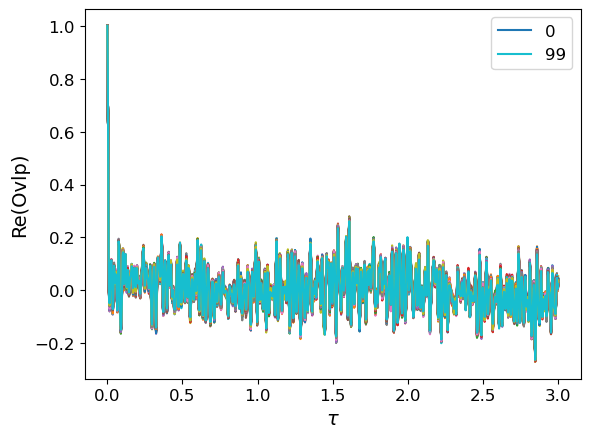

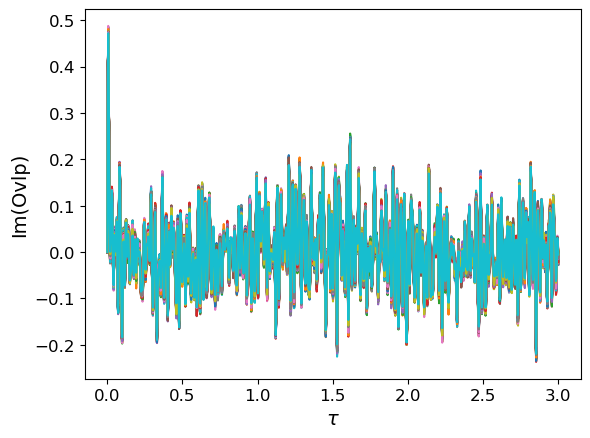

In [12]:
# Just plot all the overlap data
fig = plt.figure(1)
ax = fig.add_subplot(111)
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)
for key in ovlp_data:
    if key == list(ovlp_data.keys())[0] or key == list(ovlp_data.keys())[-1]:
        ax.plot(τs, ovlp_data[key].real, label=key)
        ax2.plot(τs, ovlp_data[key].imag, label=key)
    else:
        ax.plot(τs, ovlp_data[key].real)
        ax2.plot(τs, ovlp_data[key].imag)
ax.set_xlabel("$\\tau$")
ax.set_ylabel("Re(Ovlp)")
ax.legend()

ax2.set_xlabel("$\\tau$")
ax2.set_ylabel("Im(Ovlp)")

Text(0, 0.5, 'Im($\\langle\\hat{H}\\rangle$)')

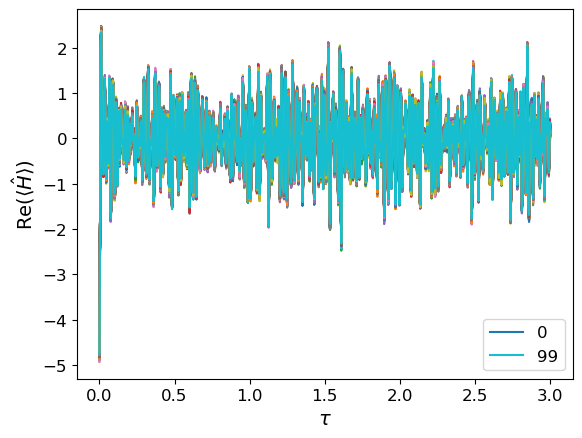

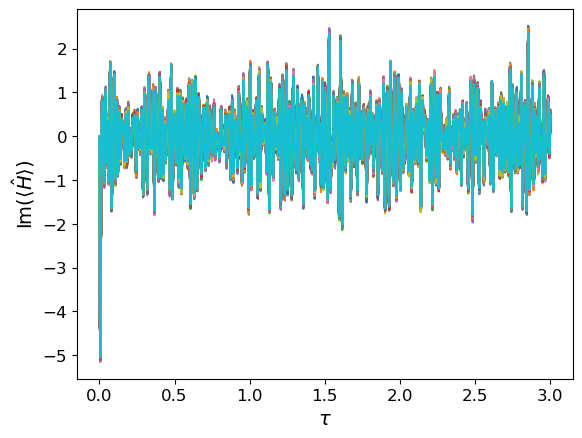

In [13]:
# Just plot all the overlap data
fig = plt.figure(1)
ax = fig.add_subplot(111)
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)
for key in ovlp_data:
    if key == list(ovlp_data.keys())[0] or key == list(ovlp_data.keys())[-1]:
        ax.plot(τs, H_ovlp_data[key].real, label=key)
        ax2.plot(τs, H_ovlp_data[key].imag, label=key)
    else:
        ax.plot(τs, H_ovlp_data[key].real)
        ax2.plot(τs, H_ovlp_data[key].imag)
ax.set_xlabel("$\\tau$")
ax.set_ylabel("Re($\\langle\\hat{H}\\rangle$)")
ax.legend()

ax2.set_xlabel("$\\tau$")
ax2.set_ylabel("Im($\\langle\\hat{H}\\rangle$)")

In [14]:
avg_ovlp = 0
avg_H_ovlp = 0
for key in ovlp_data:
    avg_ovlp += ovlp_data[key]
    avg_H_ovlp += H_ovlp_data[key]
    
avg_ovlp /= len(list(ovlp_data.keys()))
avg_H_ovlp /= len(list(ovlp_data.keys()))

/home/jacob/anaconda3/envs/EnergyGaps/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, '$\\langle\\hat{H}\\rangle$')

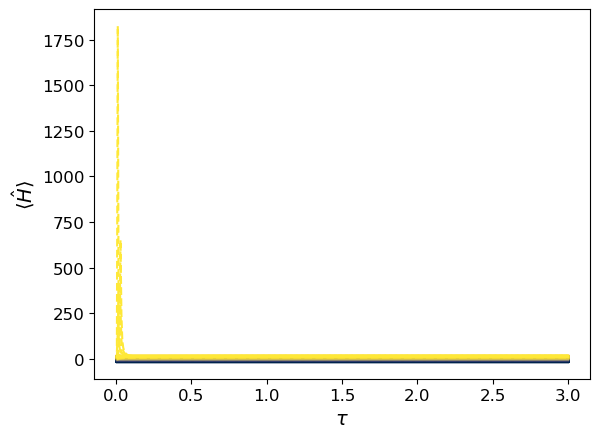

In [15]:
colors = mpl.colormaps['cividis'].resampled(E.size).colors
for i, λ in enumerate(E):
    plt.plot(τs[2::2], λ*np.ones(τs[2::2].size), color=colors[i])
    plt.plot(τs[2::2], stf.alt_partition_calc(avg_ovlp, avg_H_ovlp, num_steps, λ,
                                              dτ)[1][1:] - λ, '--', color=colors[i])
plt.xlabel("$\\tau$")
plt.ylabel("$\\langle\\hat{H}\\rangle$")

Text(0, 0.5, '$\\langle\\hat{H}\\rangle$')

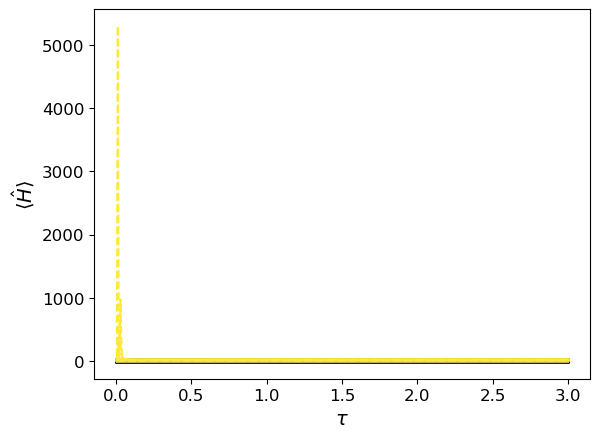

In [16]:
for i, λ in enumerate(E):
    plt.plot(τs[2::2], λ*np.ones(τs[2::2].size), color=colors[i])
    plt.plot(τs[2::2], stf.alt_partition_calc(ovlp_data['0'], H_ovlp_data['0'], num_steps, λ,
                                              dτ)[1][1:] - λ, '--', color=colors[i])
plt.xlabel("$\\tau$")
plt.ylabel("$\\langle\\hat{H}\\rangle$")

(0.0, 17.0)

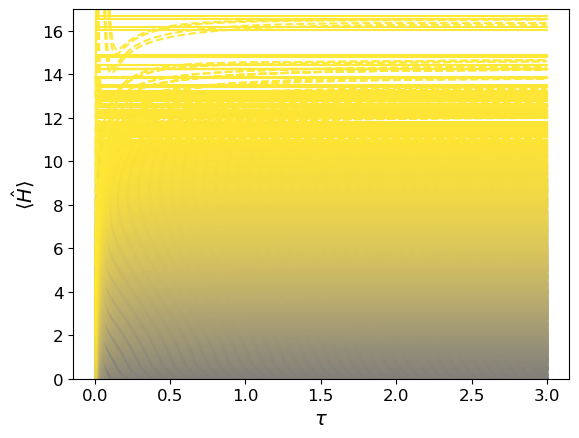

In [17]:
colors = mpl.colormaps['cividis'].resampled(E.size).colors
for i, λ in enumerate(E):
    plt.plot(τs[2::2], λ*np.ones(τs[2::2].size), color=colors[i])
    plt.plot(τs[2::2], stf.alt_partition_calc(avg_ovlp, avg_H_ovlp, num_steps, λ,
                                              dτ)[1][1:] - λ, '--', color=colors[i])
plt.xlabel("$\\tau$")
plt.ylabel("$\\langle\\hat{H}\\rangle$")
plt.ylim([0, 17])

In [18]:
E

array([-16.70525916, -16.56797193, -16.19629432, ...,  16.19629432,
        16.56797193,  16.70525916])

In [19]:
calc_E = {}
for λ in E:
    calc_E[λ] = stf.alt_partition_calc(avg_ovlp, avg_H_ovlp,
                                             num_steps, λ, dτ)[1][-1] - λ


In [20]:
λs = {}
for λ in E:
    λs[λ] = λ

In [21]:
err = {}
for λ in E:
    err[λ] = np.abs(λs[λ] - calc_E[λ])

Text(0, 0.5, 'Abs. Error')

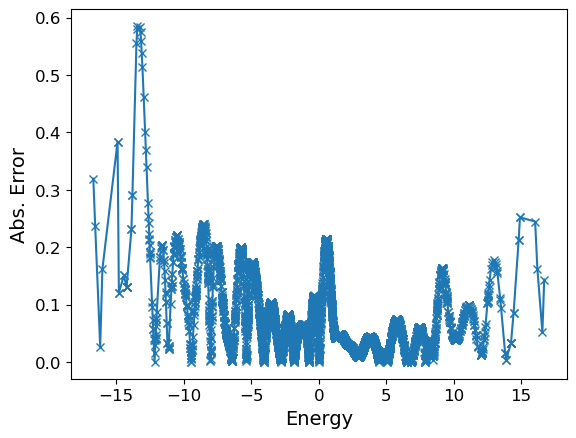

In [22]:
plt.plot(λs.values(), err.values(), 'x-')
plt.xlabel("Energy")
plt.ylabel("Abs. Error")

(-2.0, 2.0)

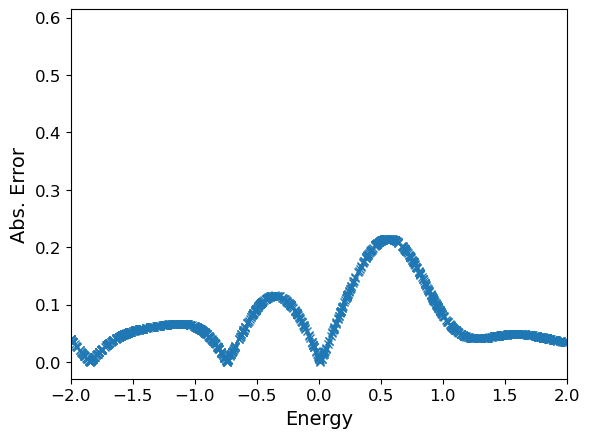

In [23]:
plt.plot(λs.values(), err.values(), 'x-')
plt.xlabel("Energy")
plt.ylabel("Abs. Error")
plt.xlim([-2, 2])